In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
subgraph_llm = ChatGroq(model="llama-3.1-8b-instant")
parent_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [10]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Bengali.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [11]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [7]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [12]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

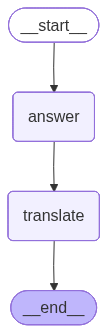

In [13]:
graph = parent_builder.compile()

graph

In [14]:
result=graph.invoke({'question': 'What is quantum physics'})

In [15]:
result

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics (also known as quantum mechanics or quantum theory) is a branch of physics that deals with the behavior of matter and energy at the smallest scales – that is, at the atomic and subatomic levels.\n\nIt\'s fundamentally different from classical physics (the physics we experience in our everyday lives, like Newton\'s laws), which describes the world of large objects. Quantum physics introduces a series of strange and counter-intuitive phenomena that govern the universe at its most fundamental level.\n\nHere\'s a breakdown of its key ideas:\n\n1.  **Quantization (The "Quantum" Part):**\n    *   The word "quantum" comes from the Latin word for "how much." In quantum physics, many physical properties like energy, momentum, and angular momentum are not continuous (like a ramp) but come in discrete, indivisible packets or steps (like stairs).\n    *   For example, electrons in an atom can only exist at specific energy leve